# Analysis
***
[Alejandro Ciuba](alejandrociuba.github.io), alc307@pitt.edu
***
## Summary
This is a continuation from the previous Jupyter Notebook (`overview.ipynb`) where I begin to analyze the data in-accordance to my proposed research questions. I might change or modify the research questions here. As such, I update both this and the main `README.md` file (not in `project_plan.md`, to retain the initial ideas for this research).
***
## Python Imports & Functions

In [1]:
# Necessary imports
import nltk
import spacy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [2]:
# Settings
# I looked this up so everything is prettier
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Use display(dataframe) to show

%pprint

Pretty printing has been turned OFF


In [3]:
# Useful functions
# Makes a boxplot with my overall preferred settings
def barplot(x:list=[], y:list=[], title:str='NO TITLE', xlabel:str='x', ylabel:str='y', xtickrot:float=0.0):

    ax = sns.barplot(x=x, y=y)
    sns.set_style(style='dark')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=xtickrot)
    plt.bar_label(ax.containers[0])    

In [4]:
# Bringing in the dataframes
FILEPATH = "../private/pickled_dfs/"

elder_scrolls_df = pd.read_pickle(FILEPATH + "elder_scrolls.pkl")
hollow_knight_df = pd.read_pickle(FILEPATH + "hollow_knight.pkl")
kotor_df = pd.read_pickle(FILEPATH + "kotor.pkl")
torchlight_df = pd.read_pickle(FILEPATH + "torchlight.pkl")

# All dfs stored in a simple list
datasets = [elder_scrolls_df, hollow_knight_df, kotor_df, torchlight_df]

***
## How Are Orders/Requests Realized in Video Game Dialogue?
This is a very broad topic. To approach this topic, let's first consider common phrases which indicate orders and requests.
- Direct Orders:
    1. _(Don't/Do not) mand. form X._
    2. _I order/demand/force (that) you X._ (Performative Speech Act)
- Indirect Orders:
    1. _You /need to/have to/must X._
    2. _Your objective/goal/quest/task is X._
    3. _X need/want/require (that)/desire that you Y._ 
    4. _Let's/Let us X._
- Direct Requests:
    1. _Please X._
    2. _I request (that you)/ask (of you) X._ (Performative Speech Act)
- Indirect Requests:
    1. _X would like (that) you Y._
    2. _May/Would/Can/Could you X?_
    3. _Is it possible to/that you X?_
    4. _Are you able to X?_

This is obviously not an exhastive list, but it does cover the most common forms that orders and requests can take.

***
## Exploring Usage of the 2nd Person Pronoun and Other Pronouns and Pro-verbs.
First, focusing on _you_ (not "you-you", but _you_, the word), let's simply graph the number of occurrences in each of the datasets. To do this, we must consider what forms of you could appear in the dataset. Obviously, the biggest concerns would be contractions (_you're_, _you'd_), but what about _y'all_? Since _y'all_ can refer **both** to an individual and a group of people, I chose to ignore it for two reasons:
1. I am want to focus on the 2nd person **singular** pronoun to see how it is used in relation to the player.
2. Overall occurrences of _y'all_ are low, and the times they refer directly to the player is even lower; this means we can ignore it without the concern of data-skewing.

Below, I have created a function which, given a compiled regular expression, will find all instances of that regular expression for each textual item in a dataframe's column. I have compiled a relatively simple regex to capture all the _you_ instances I am after. I then plot the number of _you_ occurrences for each dataset.

In [5]:
you_re = re.compile(r"\byou\b", re.IGNORECASE)

# Function such that it counts all instances of the given regular expression for each item in a dataframe's specified column
def locator(series: pd.Series, regex:re.Pattern) -> int:

    count = 0
    for item in series:
        if x := regex.findall(item):
            count += len(x)

    return count

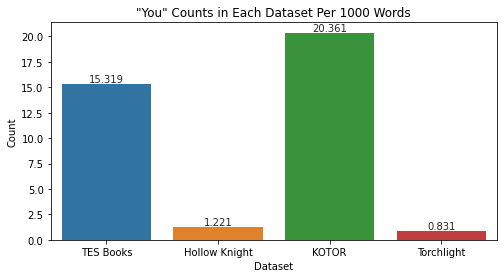

In [6]:
titles = ["TES Books", "Hollow Knight", "KOTOR", "Torchlight"]
counts = np.array([locator(elder_scrolls_df['text'], you_re), locator(hollow_knight_df['text'], you_re), 
                   locator(kotor_df['text'], you_re), locator(torchlight_df['text'], you_re)])

plt.figure(figsize=(8,4))
barplot(x=titles, y=counts/1000, title='"You" Counts in Each Dataset Per 1000 Words', xlabel="Dataset", ylabel="Count")
plt.show()

In [7]:
# Now, let's normalize these by getting them as percentages, 
# Hollowknight suffers from some slight inaccuracies due to its tagging system
def get_count(col:pd.Series) -> int:
    count = 0
    for text in col:
        count += len(nltk.word_tokenize(text))
    return count

percentages = np.array([])

for (i, c) in enumerate(counts):
    percentages = np.append(percentages, counts[i]/get_count(datasets[i]['text']))

print(percentages)

[0.00799316 0.02830189 0.03653764 0.02430749]


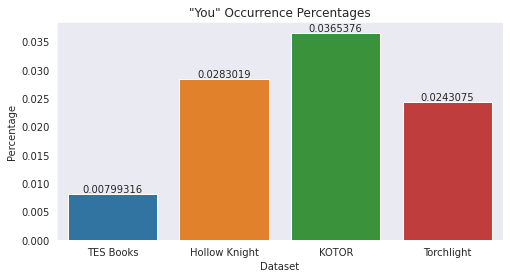

In [8]:
plt.figure(figsize=(8,4))
barplot(x=titles, y=percentages, title='"You" Occurrence Percentages', xlabel="Dataset", ylabel="Percentage")
plt.show()

This makes sense given that the data for _Hollow Knight_, _KOTOR_, and _Torchlight_ all relate to directing the player and giving the players objectives/quests in some way, shape, or form. The dataset pertaining to _The Elder Scrolls_ however, does not. Since its dataset is that of books written to be read by the player in-game, it makes sense that there is an extremely low frequency of the 2nd person pronoun. I expect this to change with other pronouns.

### Other Pronouns
Let's do this same thing for some other common pronouns: _I/me_, _he/she/him/her_, _we/us_, _they/them_. The reason I chose to go with these forms is because these forms can appear in the same contexts that _you_ would appear in. In other words, I'm simply leaving out posessive pronouns. Of course, just like with _you_, I have to consider some contractions, but those have been treated the same way as before.

In [9]:
# List of regexes
fp_re = re.compile(r"\b(?:I|me)\b")
tp_re = re.compile(r"\b(?:(?:s)?he|(?:h)(?:er|im))\b", re.IGNORECASE)
fpp_re = re.compile(r"\b(?:we|us)\b", re.IGNORECASE)
tpp_re = re.compile(r"\bthe(?:y|m)\b", re.IGNORECASE)

re_dict = {"First Person Singular": fp_re, "Third Person Singular": tp_re, "First Person Plural": fpp_re, "Third Person Plural": tpp_re}

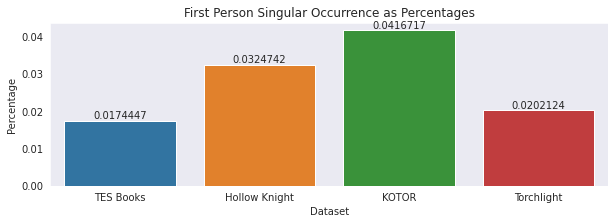

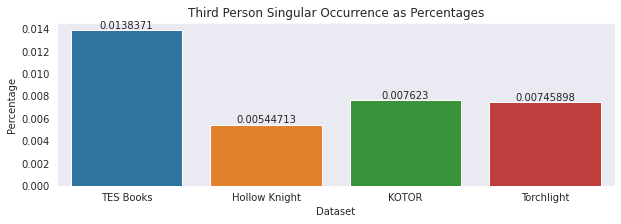

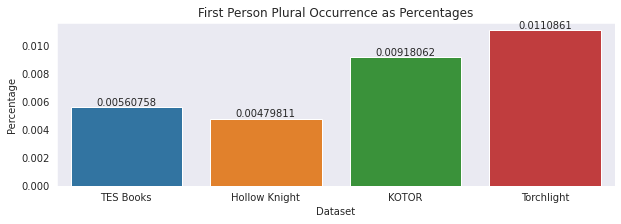

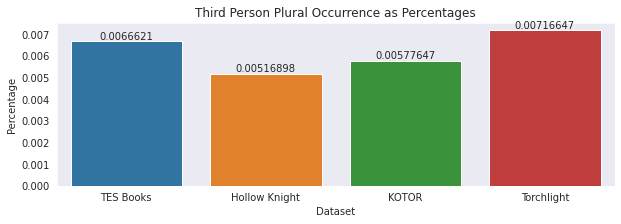

In [10]:
# Loop through everything
for pronoun in re_dict.keys():

    percentages = np.array([])
    plt.figure(figsize=(10, 3))

    for (i, c) in enumerate(datasets):
        percentages = np.append(percentages, locator(datasets[i]['text'], re_dict[pronoun])/get_count(datasets[i]['text']))

    barplot(x=titles, y=percentages, title= pronoun + ' Occurrence as Percentages', xlabel="Dataset", ylabel="Percentage")

plt.show()